In [201]:
import numpy as np
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from scipy.interpolate import interp1d
from scipy.spatial.distance import directed_hausdorff
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import CubicSpline
from scipy.interpolate import UnivariateSpline
# import scienceplots
# plt.style.use('science')

class DifferentialDriveRobot:
    def __init__(self, R, L):
        self.R = R  # Raio da roda
        self.L = L  # Distância entre as rodas
        print('self.R', self.R)
        print('self.L', self.L)
        
        # Estados iniciais
        self.x = 0
        self.y = 0
        self.theta = 0

    def update(self, v_R, v_L, dt):
        v = (self.R / 2) * (v_R + v_L)
        omega = (self.R / self.L) * (v_R - v_L)
        
        self.theta += omega * dt
        self.x += v * np.cos(self.theta) * dt
        self.y += v * np.sin(self.theta) * dt


class MPCController:
    """
    ### MPC Controller Class \n
    :param DifferentialDriveRobot robot: A robot model
    :param int N: Prediction Horizon
    :param float Q: Penalty for tracking error
    :param float R: Penalty for control effort
    :param float dt: Time interval
    :param max_margin: A margin of robot maximum offset
    """
    def __init__(self, robot, N, Q, R, dt, max_margin):
        self.robot = robot
        self.N = N  
        self.Q = Q  
        self.R = R  
        self.dt = dt
        self.max_margin = max_margin  # Distância máxima permitida da trajetória de referência

    def solve(self, x_ref, y_ref, disable_constrain = False):
        model = pyo.ConcreteModel()

        model.N = self.N
        model.dt = self.dt
        model.Q = self.Q
        model.R = self.R
        model.x_ref = x_ref
        model.y_ref = y_ref

        # Variáveis de otimização
        model.v_R = pyo.Var(range(model.N), domain=pyo.Reals)
        model.v_L = pyo.Var(range(model.N), domain=pyo.Reals)

        # Estados
        model.x = pyo.Var(range(model.N+1), domain=pyo.Reals, initialize=0)
        model.y = pyo.Var(range(model.N+1), domain=pyo.Reals, initialize=0)
        model.theta = pyo.Var(range(model.N+1), domain=pyo.Reals, initialize=0)

        # Estados iniciais
        model.x[0].fix(self.robot.x)
        model.y[0].fix(self.robot.y)
        model.theta[0].fix(self.robot.theta)

        # Variável auxiliar para a Distância de Hausdorff
        model.hausdorff_dist = pyo.Var()

        # Função custo
        def objective_rule(model):
            cost = 0
            for t in range(1, model.N):
                cost += model.Q * ((model.x[t] - model.x_ref[t])**2 + (model.y[t] - model.y_ref[t])**2)
                # cost += model.R * (model.v_R[t]**2 + model.v_L[t]**2)
                # cost += model.R * ((model.v_R[t] - model.v_L[t])**2)
                cost += model.R * ((model.v_R[t] - model.v_R[t-1])**2 + (model.v_L[t] - model.v_L[t-1])**2)
   
            return cost
        
        model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

        # Restrições de dinâmica
        model.dynamics = pyo.ConstraintList()
        for t in range(model.N):
            v = (self.robot.R / 2) * (model.v_R[t] + model.v_L[t])
            omega = (self.robot.R / self.robot.L) * (model.v_R[t] - model.v_L[t])
            model.dynamics.add(model.x[t+1] == model.x[t] + v * pyo.cos(model.theta[t] + omega) * model.dt)
            model.dynamics.add(model.y[t+1] == model.y[t] + v * pyo.sin(model.theta[t] + omega) * model.dt)
            model.dynamics.add(model.theta[t+1] == model.theta[t] + omega * model.dt)

        if not disable_constrain:
            # Limites das variáveis de controle
            def control_limits_rule_R(model, t):
                return (-1, model.v_R[t], 1)
            
            def control_limits_rule_L(model, t):
                return (-1, model.v_L[t], 1)

            model.control_limits_R = pyo.Constraint(range(model.N), rule=control_limits_rule_R)
            model.control_limits_L = pyo.Constraint(range(model.N), rule=control_limits_rule_L)

            # Hausdorff_constraint of margin
            # def hausdorff_constraint(model):
            #     # Listas de pontos da trajetória atual e da referência
            #     traj_pred = [(model.x[i].value, model.y[i].value) for i in range(self.N)]
            #     traj_ref = [(model.x_ref[i], model.y_ref[i]) for i in range(self.N)]

            #     # Calcula a Distância de Hausdorff em ambas direções
            #     hd_dist_1 = directed_hausdorff(traj_pred, traj_ref)[0]
            #     hd_dist_2 = directed_hausdorff(traj_ref, traj_pred)[0]
                
            #     # Define a Distância de Hausdorff como o máximo entre as duas direções
            #     model.hausdorff_dist.set_value(max(hd_dist_1, hd_dist_2))

            #     # Restrições para garantir que a Distância de Hausdorff fique dentro do limite
            #     return model.hausdorff_dist <= self.max_margin

            # Adiciona a restrição de Hausdorff ao modelo
            # model.hausdorff_constraint = pyo.Constraint(rule=hausdorff_constraint)

        # Solver
        solver = SolverFactory('ipopt')
        result = solver.solve(model, tee=False)

        # Extrair os valores de controle resultantes
        out_X = [model.x[i]() for i in range(self.N)]
        out_Y = [model.y[i]() for i in range(self.N)]

        out_v_R = [model.v_R[i]() for i in range(self.N)]
        out_v_L = [model.v_L[i]() for i in range(self.N)]
        out_theta = [model.theta[i]() * 180/np.pi for i in range(self.N)]
        out_omega = [(self.robot.R / self.robot.L) * (model.v_R[i]() - model.v_L[i]())*180/np.pi for i in range(self.N)]
        
        print('out_X', out_X)
        print('out_Y', out_Y)
        print('out_v_R', out_v_R)
        print('out_v_L', out_v_L)
        print('out_theta', out_theta)
        print('out_omega', out_omega)
        return model.v_R[0].value, model.v_L[0].value, [out_X, out_Y], [out_v_R, out_v_L]

# Parâmetros do robô
radius_wheel = 0.05     # Raio da roda em metros
distance_wheel = 0.10   # Distância entre as rodas em metros

# Criar instância do robô diferencial
robot = DifferentialDriveRobot(radius_wheel, distance_wheel)

# Criar instância do controlador MPC
predict_horizon = 15
margin = 0.1  # Distância da margem em metros
delta_time = 1
mpc = MPCController(robot, N=predict_horizon, Q=1, R=0.025, dt=delta_time, max_margin=margin)
plt_path = './assets/greentrack/out1/'
plt_sim_path = plt_path + 'simulation/'
# Referência de trajetória
# in_points = [[-0.09150369689456136, 0.48914467381475923], [-0.09846197449972373, 0.5594131906773301], [-0.10708867633569592, 0.6468840483426161], [-0.11807990084029595, 0.7587300914046574], [-0.13122400333321313, 0.9066888477317598], [-0.15099370681792523, 1.111769544992076]]
# 00
in_points = [[-0.017848055284399953, 0.48760301399543426], [-0.018155616076678177, 0.5573750648184183], [-0.01653307457469192, 0.644070401174944], [-0.014430030465412075, 0.7547220360274914], [-0.010287218535510213, 0.9007575459532651], [-0.002919931539156326, 1.102307692488813]]
# 01
# in_points = [[0.13566351007347296, 0.48669379024359827], [0.15934192098490663, 0.5552483203251758], [0.18870974626590875, 0.6400768002582645], [0.22606614164987102, 0.7477511492535487], [0.27389839448259967, 0.8889719702991565], [0.3394855033173343, 1.0823141512561656]]
# # 02
# in_points = [[-0.17027170118508278, 0.4917552484423625], [-0.19732673012303623, 0.5631604140544749], [-0.23121361347165922, 0.6523578741566183], [-0.27605503891199734, 0.767030532990663], [-0.3359510962813893, 0.9198344855171328], [-0.4216666150892573, 1.1338310373350362]]
# # 03
# in_points = [[-0.034569015737419335, 0.48788981092853656], [-0.049244004301635565, 0.5580846409100513], [-0.0646460802602162, 0.6454870182869393], [-0.08216615857620639, 0.7572783840825184], [-0.09872907273243714, 0.9050550675973639], [-0.11038975592794661, 1.109163383074129]]

Xc = []
Yc = []
for point in in_points:
    Xc.append(point[1])
    Yc.append(point[0])

print('Xc: ', Xc)
print('Yc: ', Yc)

cs = CubicSpline([0] + Xc, [0] + Yc)
x_smooth_raw = np.linspace(0, Xc[-1], num=25)
y_smooth_raw = cs(x_smooth_raw)



self.R 0.05
self.L 0.1
Xc:  [0.48760301399543426, 0.5573750648184183, 0.644070401174944, 0.7547220360274914, 0.9007575459532651, 1.102307692488813]
Yc:  [-0.017848055284399953, -0.018155616076678177, -0.01653307457469192, -0.014430030465412075, -0.010287218535510213, -0.002919931539156326]


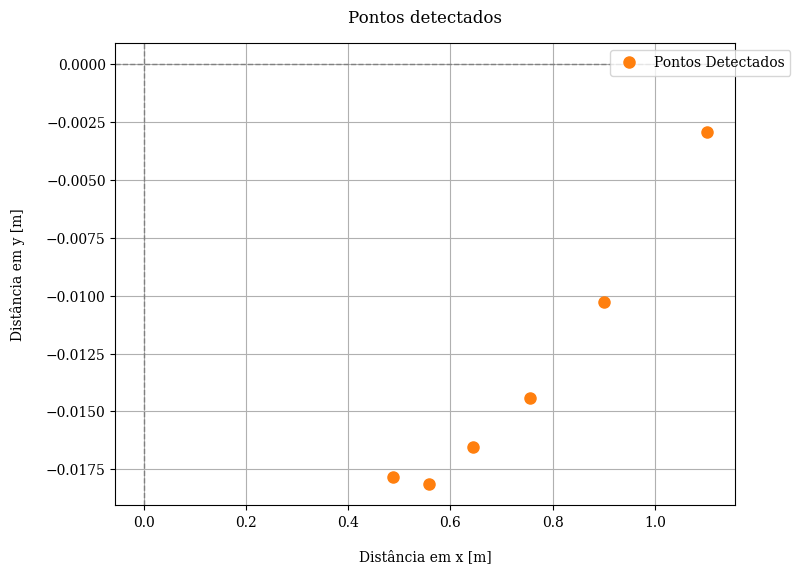

<Figure size 640x480 with 0 Axes>

In [202]:

plt.figure(figsize=(8, 6))
plt.plot([], [], 'o-', markersize=8)
plt.plot(Xc, Yc, 'o', label='Pontos Detectados', markersize=8)

plt.rcParams['font.family'] = 'serif'

plt.axhline(0, color='gray', linewidth=1, linestyle='--')  # Linha horizontal
plt.axvline(0, color='gray', linewidth=1, linestyle='--')  # Linha vertical
plt.xlabel('Distância em x [m]', labelpad=15)
plt.ylabel('Distância em y [m]', labelpad=15)

plt.title('Pontos detectados', pad=15)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), borderaxespad=0.5)

plt.grid(True)
plt.savefig(plt_path + 'detected_points_plot')
plt.show()
plt.clf()

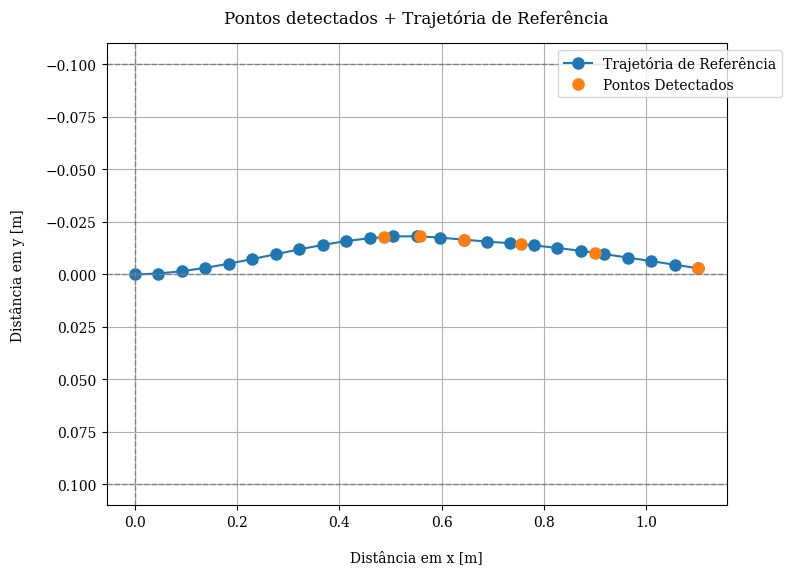

<Figure size 640x480 with 0 Axes>

In [203]:
# ------------------------------------------------------
#  Plot pontos detectados + Trajetória de Referência
plt.figure(figsize=(8, 6))
plt.plot(x_smooth_raw, y_smooth_raw, 'o-', label='Trajetória de Referência', markersize=8)
plt.plot(Xc, Yc, 'o', label='Pontos Detectados', markersize=8)

plt.rcParams['font.family'] = 'serif'
# Adicionando linhas verticais e horizontais passando pela origem (0, 0)
plt.axhline(0, color='gray', linewidth=1, linestyle='--')  # Linha horizontal
plt.axvline(0, color='gray', linewidth=1, linestyle='--')  # Linha vertical
plt.axhline(-0.10, color='gray', linewidth=1, linestyle='--')  # Linha vertical
plt.axhline(0.1, color='gray', linewidth=1, linestyle='--')  # Linha vertical
plt.xlabel('Distância em x [m]', labelpad=15)
plt.ylabel('Distância em y [m]', labelpad=15)
# plt.title('Pontos detectados + Trajetória de Referência', pad=15)
plt.title('Pontos detectados + Trajetória de Referência', pad=15)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), borderaxespad=0.5)
plt.gca().invert_yaxis()
plt.grid(True)
plt.savefig(plt_path + 'trajectory')
plt.show()
plt.clf()

x_interpolado [0.         0.49914467 0.53941319 0.68688405 0.72730091 0.91668885
 1.12176954]
y_interpolado [ 0.         -0.0715037  -0.09461974 -0.11708868 -0.1080799  -0.121224
 -0.17099371]


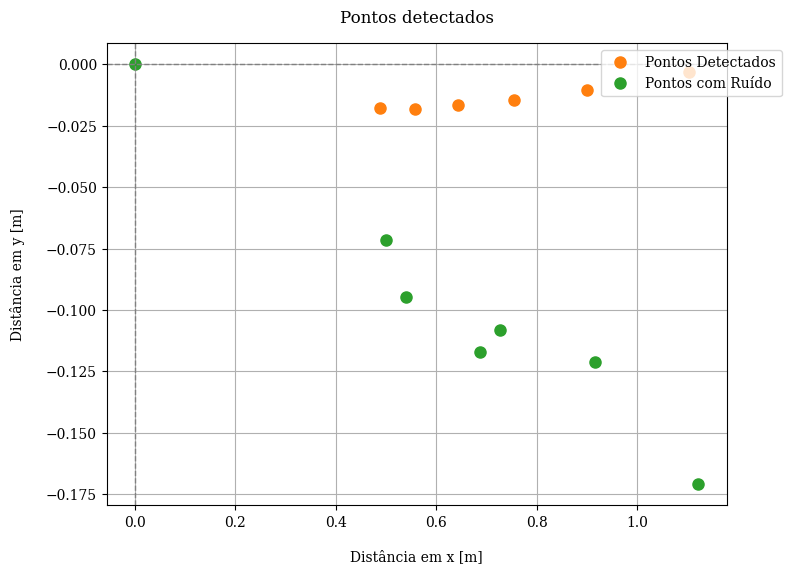

<Figure size 640x480 with 0 Axes>

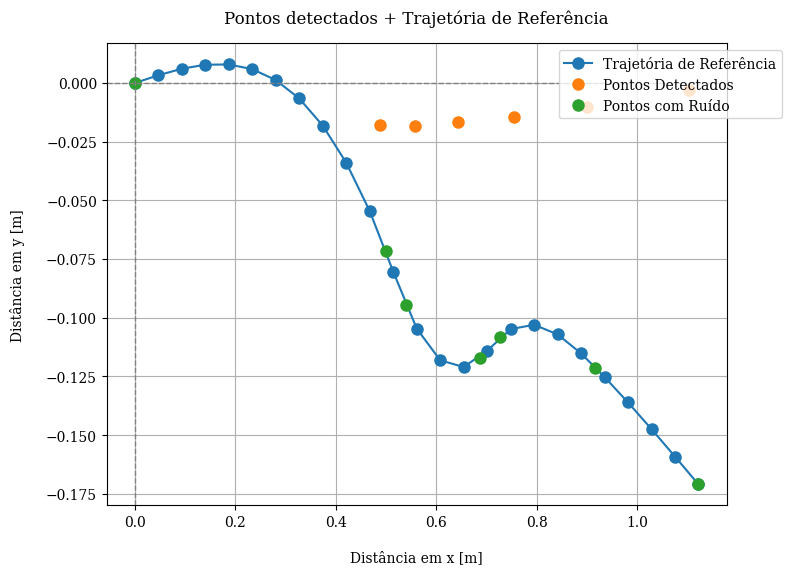

<Figure size 640x480 with 0 Axes>

In [204]:
# ------------------------------------------------------
#  Plot pontos detectados
# Parâmetros do ruído
ruido_intensidade = 0.01  # Ajuste o valor para controlar a intensidade do ruído

# Adiciona ruído gaussiano
x_ref_ruido = Xc + np.random.normal(0, ruido_intensidade, size=len(Xc))
y_ref_ruido = Yc + np.random.normal(0, ruido_intensidade, size=len(Yc))

# Xc:  [0.48914467381475923, 0.5594131906773301, 0.6468840483426161, 0.7587300914046574, 0.9066888477317598, 1.111769544992076]
# Yc:  [-0.09150369689456136, -0.09846197449972373, -0.10708867633569592, -0.11807990084029595, -0.13122400333321313, -0.15099370681792523]
x_ref_ruido = [0.49914467381475923, 0.5394131906773301, 0.6868840483426161, 0.727300914046574, 0.9166888477317598, 1.121769544992076]
y_ref_ruido = [-0.07150369689456136, -0.0946197449972373, -0.11708867633569592, -0.10807990084029595, -0.12122400333321313, -0.17099370681792523]

x_prefix = np.linspace(0, x_ref_ruido[0], 2)
y_prefix = np.linspace(0, y_ref_ruido[0], 2)

# # Concatena o prefixo com os pontos ruidosos
x_interpolado = np.concatenate((x_prefix, x_ref_ruido[1:]))
y_interpolado = np.concatenate((y_prefix, y_ref_ruido[1:]))

print('x_interpolado', x_interpolado)
print('y_interpolado', y_interpolado)

# # Cria a spline cúbica com os pontos concatenados
cs = CubicSpline(x_interpolado, y_interpolado, bc_type='natural')

# # Gera os pontos suavizados
x_smooth = np.linspace(0, x_interpolado[-1], num=25)
y_smooth = cs(x_smooth)

plt.figure(figsize=(8, 6))
plt.plot([], [], 'o-', markersize=8)
plt.plot(Xc, Yc, 'o', label='Pontos Detectados', markersize=8)
plt.plot(x_interpolado, y_interpolado, 'o', label='Pontos com Ruído', markersize=8)

plt.rcParams['font.family'] = 'serif'

plt.axhline(0, color='gray', linewidth=1, linestyle='--')  # Linha horizontal
plt.axvline(0, color='gray', linewidth=1, linestyle='--')  # Linha vertical
plt.xlabel('Distância em x [m]', labelpad=15)
plt.ylabel('Distância em y [m]', labelpad=15)

plt.title('Pontos detectados', pad=15)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), borderaxespad=0.5)

plt.grid(True)
plt.savefig(plt_path + 'detected_points_cubic')
plt.show()
plt.clf()

# ------------------------------------------------------
#  Plot pontos detectados + Trajetória de Referência
plt.figure(figsize=(8, 6))
plt.plot(x_smooth, y_smooth, 'o-', label='Trajetória de Referência', markersize=8)
plt.plot(Xc, Yc, 'o', label='Pontos Detectados', markersize=8)
plt.plot(x_interpolado, y_interpolado, 'o', label='Pontos com Ruído', markersize=8)

plt.rcParams['font.family'] = 'serif'
# Adicionando linhas verticais e horizontais passando pela origem (0, 0)
plt.axhline(0, color='gray', linewidth=1, linestyle='--')  # Linha horizontal
plt.axvline(0, color='gray', linewidth=1, linestyle='--')  # Linha vertical
plt.xlabel('Distância em x [m]', labelpad=15)
plt.ylabel('Distância em y [m]', labelpad=15)
# plt.title('Pontos detectados + Trajetória de Referência', pad=15)
plt.title('Pontos detectados + Trajetória de Referência', pad=15)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), borderaxespad=0.5)

plt.grid(True)
plt.savefig(plt_path + 'trajectory_cubic')
plt.show()
plt.clf()

x_interpolado [0.         0.49914467 0.53941319 0.68688405 0.72730091 0.91668885
 1.12176954]
y_interpolado [ 0.         -0.0715037  -0.09461974 -0.11708868 -0.1080799  -0.121224
 -0.17099371]


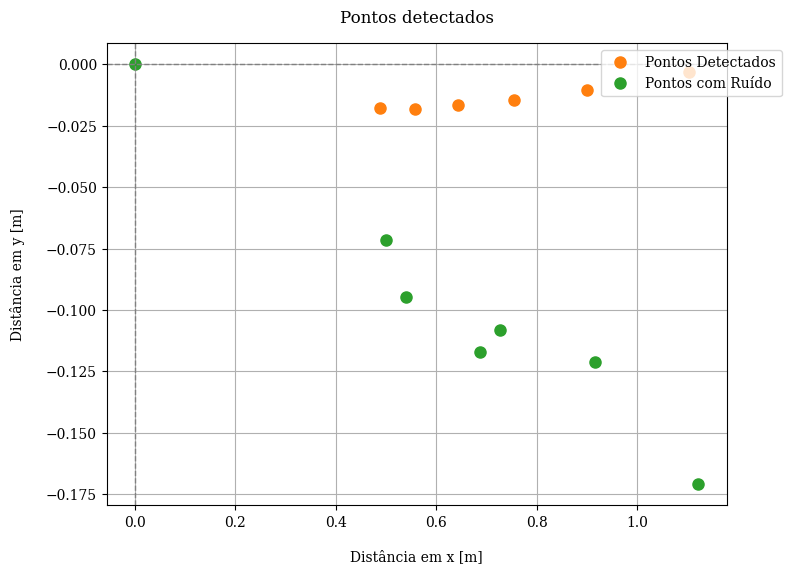

<Figure size 640x480 with 0 Axes>

In [205]:
# ------------------------------------------------------
#  Plot pontos detectados
# Parâmetros do ruído
ruido_intensidade = 0.01  # Ajuste o valor para controlar a intensidade do ruído

# Adiciona ruído gaussiano
x_ref_ruido = Xc + np.random.normal(0, ruido_intensidade, size=len(Xc))
y_ref_ruido = Yc + np.random.normal(0, ruido_intensidade, size=len(Yc))

# Xc:  [0.48914467381475923, 0.5594131906773301, 0.6468840483426161, 0.7587300914046574, 0.9066888477317598, 1.111769544992076]
# Yc:  [-0.09150369689456136, -0.09846197449972373, -0.10708867633569592, -0.11807990084029595, -0.13122400333321313, -0.15099370681792523]
x_ref_ruido = [0.49914467381475923, 0.5394131906773301, 0.6868840483426161, 0.727300914046574, 0.9166888477317598, 1.121769544992076]
y_ref_ruido = [-0.07150369689456136, -0.0946197449972373, -0.11708867633569592, -0.10807990084029595, -0.12122400333321313, -0.17099370681792523]

x_prefix = np.linspace(0, x_ref_ruido[0], 2)
y_prefix = np.linspace(0, y_ref_ruido[0], 2)

# # Concatena o prefixo com os pontos ruidosos
x_interpolado = np.concatenate((x_prefix, x_ref_ruido[1:]))
y_interpolado = np.concatenate((y_prefix, y_ref_ruido[1:]))

print('x_interpolado', x_interpolado)
print('y_interpolado', y_interpolado)

# # Cria a spline cúbica com os pontos concatenados
cs = UnivariateSpline(x_interpolado, y_interpolado, s=1.5)

# # Gera os pontos suavizados
x_smooth = np.linspace(0, x_interpolado[-1], num=25)
y_smooth = cs(x_smooth)

plt.figure(figsize=(8, 6))
plt.plot([], [], 'o-', markersize=8)
plt.plot(Xc, Yc, 'o', label='Pontos Detectados', markersize=8)
plt.plot(x_interpolado, y_interpolado, 'o', label='Pontos com Ruído', markersize=8)

plt.rcParams['font.family'] = 'serif'

plt.axhline(0, color='gray', linewidth=1, linestyle='--')  # Linha horizontal
plt.axvline(0, color='gray', linewidth=1, linestyle='--')  # Linha vertical
plt.xlabel('Distância em x [m]', labelpad=15)
plt.ylabel('Distância em y [m]', labelpad=15)

plt.title('Pontos detectados', pad=15)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), borderaxespad=0.5)

plt.grid(True)
plt.savefig(plt_path + 'detected_points_ruido')
plt.show()
plt.clf()

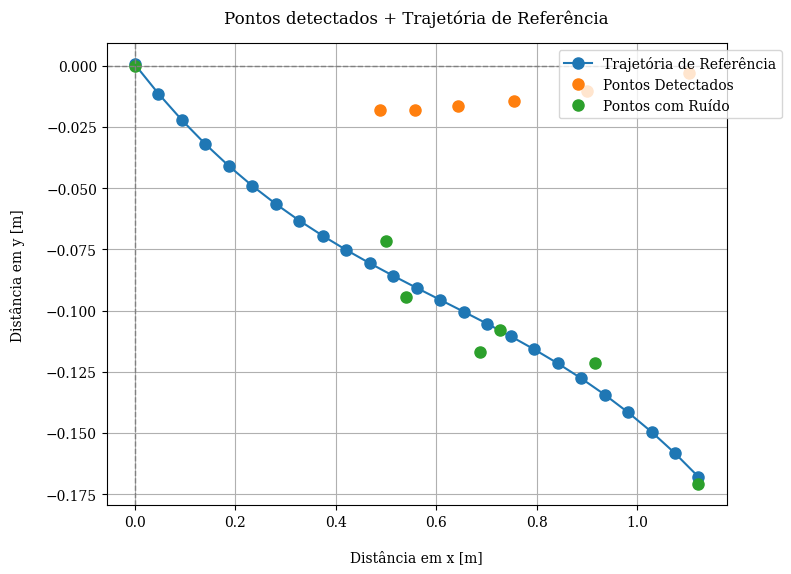

<Figure size 640x480 with 0 Axes>

In [206]:
# ------------------------------------------------------
#  Plot pontos detectados + Trajetória de Referência
plt.figure(figsize=(8, 6))
plt.plot(x_smooth, y_smooth, 'o-', label='Trajetória de Referência', markersize=8)
plt.plot(Xc, Yc, 'o', label='Pontos Detectados', markersize=8)
plt.plot(x_interpolado, y_interpolado, 'o', label='Pontos com Ruído', markersize=8)

plt.rcParams['font.family'] = 'serif'
# Adicionando linhas verticais e horizontais passando pela origem (0, 0)
plt.axhline(0, color='gray', linewidth=1, linestyle='--')  # Linha horizontal
plt.axvline(0, color='gray', linewidth=1, linestyle='--')  # Linha vertical
plt.xlabel('Distância em x [m]', labelpad=15)
plt.ylabel('Distância em y [m]', labelpad=15)
# plt.title('Pontos detectados + Trajetória de Referência', pad=15)
plt.title('Pontos detectados + Trajetória de Referência', pad=15)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), borderaxespad=0.5)

plt.grid(True)
plt.savefig(plt_path + 'trajectory_ruido')
plt.show()
plt.clf()

self.R 0.05
self.L 0.1


out_X [0, 0.04674040769728994, 0.09348078469927615, 0.1402211995989033, 0.18696158869582058, 0.23370198875737708, 0.28044238634031554, 0.3271827839395873, 0.3739231816360068, 0.42066357934035964, 0.46740397743775103, 0.5141443738724458, 0.5608847737120092, 0.6076251694190855, 0.6543655680893354]
out_Y [0, -0.011299858260938258, -0.022114195284853026, -0.03194293872264728, -0.04087514434555392, -0.04899939800268506, -0.056404530249629894, -0.06317929094063209, -0.06941244220582757, -0.07519274728795697, -0.0806089653558411, -0.08574988119989559, -0.09070419432646257, -0.09556078004966283, -0.10040827149345848]
out_v_R [0.7245321471625197, 0.9693394138221695, 0.9753586430818663, 0.970162375543529, 0.9655529221452172, 0.9614392535352304, 0.9577596893805319, 0.9544510407968887, 0.9514602936156482, 0.9487426340067497, 0.946261189381442, 0.9439910227952999, 0.94190869383747, 0.9400144088194055, 0.018011651042459324]
out_v_L [1.1989449152764302, 0.9496656277983635, 0.9351472911983175, 0.93328

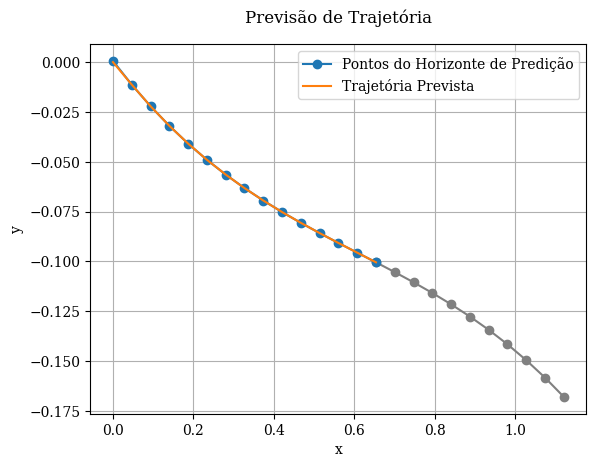

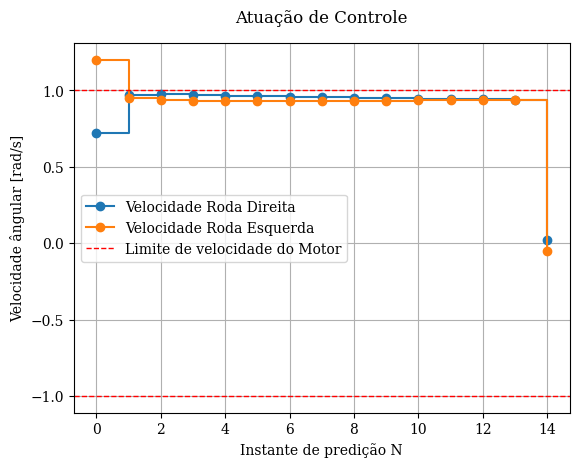

<Figure size 640x480 with 0 Axes>

In [207]:

# # Trajetória interpolada
x_ref = x_smooth
y_ref = y_smooth

# # # Simulação
dt = delta_time
x_traj = [0]
y_traj = [0]
v_out = []

robot_2 = DifferentialDriveRobot(radius_wheel, distance_wheel)
mpc_2 = MPCController(robot_2, N=predict_horizon, Q=1, R=0, dt=delta_time, max_margin=margin)
v_R, v_L, [out_x, out_y], [out_v_R, out_v_L] = mpc_2.solve(x_ref[0:predict_horizon], y_ref[0:predict_horizon], disable_constrain=True)
v_out.append((v_R, v_L))
robot.update(v_R, v_L, dt)
x_traj.append(robot.x)
y_traj.append(robot.y)

# Plotar trajetória 
plt.plot(x_ref[predict_horizon - 1:], y_ref[predict_horizon - 1:], 'o-',color='grey')
plt.plot(x_ref[0:predict_horizon], y_ref[0:predict_horizon], 'o-', label='Pontos do Horizonte de Predição')
plt.plot(out_x, out_y, '-', label='Trajetória Prevista')
# plt.plot(x_traj, y_traj, label='Trajetória do Robô')
# plt.fill_between(x_ref, y_margin_inf, y_margin_sup, color='gray', alpha=0.3, label=f'Margem de {margin} m')

plt.title('Previsão de Trajetória', pad=15)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.savefig(plt_path + 'trajectory_predicted')
plt.show()
plt.clf() 

# Plotar Velocidade
plt.title('Atuação de Controle', pad=15)
plt.step(range(len(out_v_R)), out_v_R, 'o-', where='post', label='Velocidade Roda Direita')
plt.step(range(len(out_v_L)), out_v_L, 'o-', where='post', label='Velocidade Roda Esquerda')
# plt.plot(x_traj, y_traj, label='Trajetória do Robô')
# plt.fill_between(x_ref, y_margin_inf, y_margin_sup, color='gray', alpha=0.3, label=f'Margem de {margin} m')
plt.xlabel('Instante de predição N')
plt.ylabel('Velocidade ângular [rad/s]')
plt.axhline(1, color='red', linewidth=1, linestyle='--', label='Limite de velocidade do Motor')  # Linha horizontal
plt.axhline(-1, color='red', linewidth=1, linestyle='--')  # Linha horizontal
plt.legend()
plt.grid(True)
plt.savefig(plt_path + 'trajectory_velocity')
plt.show()
plt.clf() 


self.R 0.05
self.L 0.1
out_X [0, 0.0395902666530747, 0.0876458705224704, 0.13653917485310763, 0.18543062918124528, 0.23370473393790955, 0.2804373191378696, 0.32718273537160575, 0.37392315267259857, 0.4206635577635603, 0.4674039618922651, 0.5141443648508639, 0.5608847670961882, 0.6076251661945536, 0.6543647651456304]
out_Y [0, -0.007744829043838747, -0.018007530658239488, -0.028452476842058465, -0.0389009544751993, -0.04899110903141236, -0.05640858341509403, -0.06317929386282888, -0.06941243302058028, -0.07519274120142116, -0.08060896437713407, -0.08574986699068399, -0.09070421186429103, -0.09556078648796519, -0.10040819789848347]
out_v_R [0.6136289783871636, 0.9655712202634438, 0.9998649657933247, 0.9998321878675192, 0.9908360153375176, 0.9949944498930959, 0.9582309674076952, 0.9543516009731027, 0.9514600923223848, 0.9487427185602796, 0.9462616780844605, 0.9439901765886132, 0.9419096473882764, 0.9399980308447125, -5.613936906913174e-18]
out_v_L [0.9999987806258964, 0.9999980532744723, 

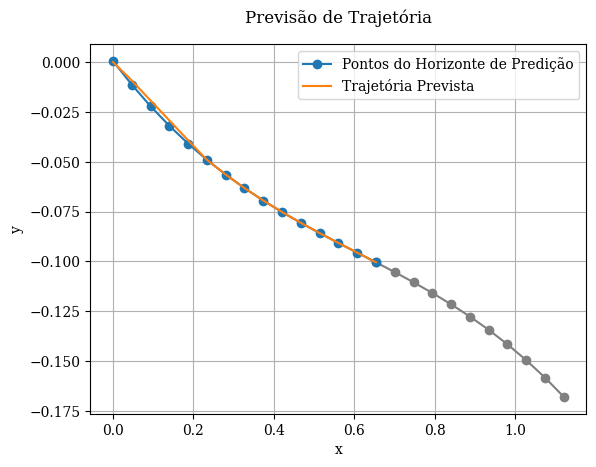

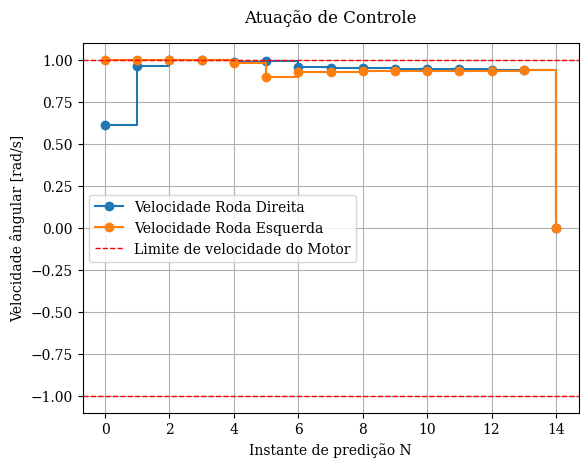

<Figure size 640x480 with 0 Axes>

In [208]:

# # Trajetória interpolada
x_ref = x_smooth
y_ref = y_smooth

# # # Simulação
dt = delta_time
x_traj = [0]
y_traj = [0]
v_out = []

robot_constrained = DifferentialDriveRobot(radius_wheel, distance_wheel)
mpc_constrained = MPCController(robot_constrained, N=predict_horizon, Q=1, R=0, dt=delta_time, max_margin=margin)

v_R, v_L, [out_x, out_y], [out_v_R, out_v_L] = mpc_constrained.solve(x_ref[0:predict_horizon], y_ref[0:predict_horizon], disable_constrain=False)
v_out.append((v_R, v_L))
robot_constrained.update(v_R, v_L, dt)
x_traj.append(robot_constrained.x)
y_traj.append(robot_constrained.y)

# Plotar trajetória 
plt.title('Previsão de Trajetória', pad=15)
plt.plot(x_ref[predict_horizon - 1:], y_ref[predict_horizon - 1:], 'o-',color='grey')
plt.plot(x_ref[0:predict_horizon], y_ref[0:predict_horizon], 'o-', label='Pontos do Horizonte de Predição')
plt.plot([0] + out_x, [0] + out_y, '-', label='Trajetória Prevista')
# plt.plot(x_traj, y_traj, label='Trajetória do Robô')
# plt.fill_between(x_ref, y_margin_inf, y_margin_sup, color='gray', alpha=0.3, label=f'Margem de {margin} m')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.savefig(plt_path + 'trajectory_predicted_constrained')
plt.show()
plt.clf() 

# Plotar Velocidade
plt.title('Atuação de Controle', pad=15)
plt.step(range(len(out_v_R)), out_v_R, 'o-', where='post', label='Velocidade Roda Direita')
plt.step(range(len(out_v_L)), out_v_L, 'o-', where='post', label='Velocidade Roda Esquerda')
# plt.plot(x_traj, y_traj, label='Trajetória do Robô')
# plt.fill_between(x_ref, y_margin_inf, y_margin_sup, color='gray', alpha=0.3, label=f'Margem de {margin} m')
plt.xlabel('Instante de predição N')
plt.ylabel('Velocidade ângular [rad/s]')
plt.axhline(1, color='red', linewidth=1, linestyle='--', label='Limite de velocidade do Motor')  # Linha horizontal
plt.axhline(-1, color='red', linewidth=1, linestyle='--')  # Linha horizontal
plt.legend()
plt.grid(True)
plt.savefig(plt_path + 'trajectory_velocity_constrained')
plt.show()
plt.clf() 


self.R 0.05
self.L 0.1
out_X [0, 0.0395902666530747, 0.0876458705224704, 0.13653917485310763, 0.18543062918124528, 0.23370473393790955, 0.2804373191378696, 0.32718273537160575, 0.37392315267259857, 0.4206635577635603, 0.4674039618922651, 0.5141443648508639, 0.5608847670961882, 0.6076251661945536, 0.6543647651456304]
out_Y [0, -0.007744829043838747, -0.018007530658239488, -0.028452476842058465, -0.0389009544751993, -0.04899110903141236, -0.05640858341509403, -0.06317929386282888, -0.06941243302058028, -0.07519274120142116, -0.08060896437713407, -0.08574986699068399, -0.09070421186429103, -0.09556078648796519, -0.10040819789848347]
out_v_R [0.6136289783871636, 0.9655712202634438, 0.9998649657933247, 0.9998321878675192, 0.9908360153375176, 0.9949944498930959, 0.9582309674076952, 0.9543516009731027, 0.9514600923223848, 0.9487427185602796, 0.9462616780844605, 0.9439901765886132, 0.9419096473882764, 0.9399980308447125, -5.613936906913174e-18]
out_v_L [0.9999987806258964, 0.9999980532744723, 

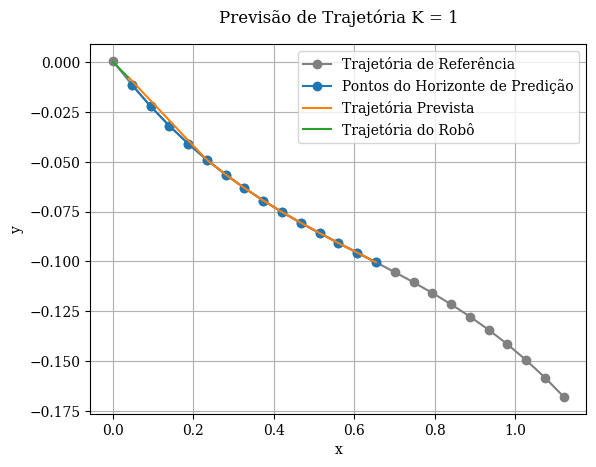

out_X [0.03681642570947693, 0.08558083644635506, 0.13455129141268324, 0.18352169134896493, 0.23248969759622487, 0.28042323972103944, 0.32718203421576697, 0.37392315392890163, 0.4206635578888696, 0.4674039618920694, 0.5141443648500191, 0.5608847671015244, 0.6076251689857493, 0.6543655649987616, 0.7011051629712034]
out_Y [-0.007419618128110067, -0.017462565350010506, -0.02754937554430762, -0.03763728510985203, -0.04772703227885988, -0.05641695425510069, -0.06318001717167289, -0.06941243041580762, -0.07519274091738842, -0.0806089643776671, -0.0857498669985083, -0.0907042118183881, -0.09556076174085312, -0.10040833240280132, -0.10533541541029758]
out_v_R [0.9915146128048157, 0.9999418471957641, 0.9999514391943983, 0.9998880690014479, 0.998158234066261, 0.9806091886174224, 0.9541799816491837, 0.9514427954553276, 0.9487427622585993, 0.9462616842464401, 0.9439901779044909, 0.9419101795587032, 0.9400120655086964, 0.9382869944603321, 1.0813233852459533e-16]
out_v_L [0.9999987933412513, 0.999997

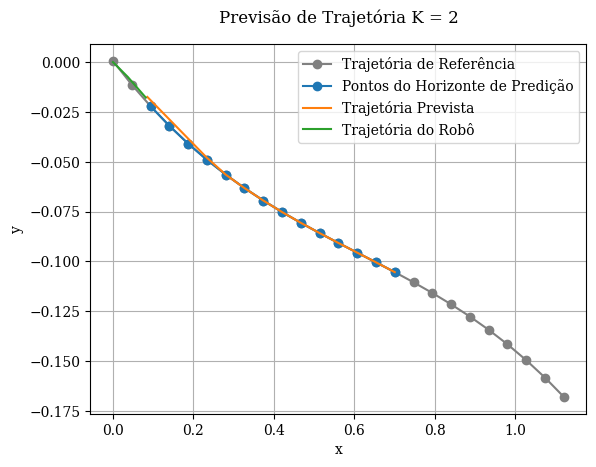

out_X [0.08168677129491778, 0.13039586040310908, 0.17867224113653116, 0.22650340688880025, 0.27470122889819215, 0.32318354397609067, 0.3717808424279767, 0.42017252380466436, 0.46740379896297923, 0.514144386711784, 0.56088476627268, 0.6076251690101271, 0.6543655708219461, 0.7011059637562777, 0.7478455566870336]
out_Y [-0.01781616495470395, -0.029101519618766693, -0.03970549522784808, -0.04892715844565458, -0.05711232263940963, -0.06437465811330044, -0.07066672119744226, -0.07560443761775508, -0.08060904146355531, -0.08574971910444999, -0.0907042131700407, -0.0955607611763904, -0.10040827888403359, -0.10533561126917607, -0.11043112307627966]
out_v_R [0.9999993095328062, 0.9999990719355989, 0.9999986595958573, 0.9999978498374065, 0.9999959211151729, 0.9999894082590411, 0.9999315161294211, 0.9460324603622913, 0.9364713484558557, 0.9439816470953076, 0.9419134430256164, 0.9400131626747197, 0.9382986917156264, 0.9367714278184502, 9.67702408983329e-17]
out_v_L [0.9999745194901538, 0.9770910028

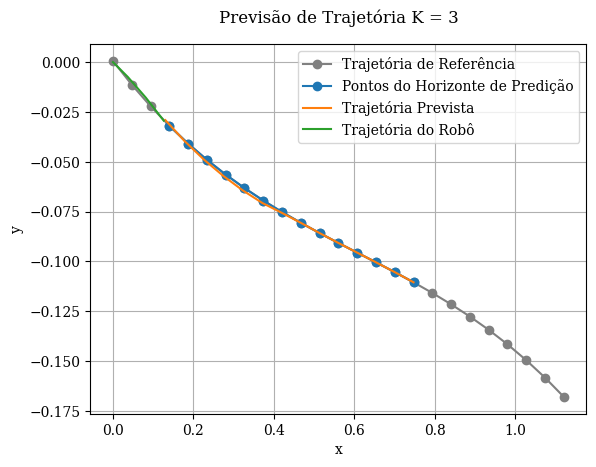

out_X [0.12646763061835223, 0.17306761654786243, 0.2212384513914273, 0.26972463880755554, 0.3183889512210089, 0.367203628140312, 0.416124946057718, 0.4650416662645761, 0.5136356158348362, 0.5608845755513974, 0.6076251690316777, 0.6543655708410238, 0.7011059728728943, 0.7478463621918998, 0.7945859462486423]
out_Y [-0.029378159770051503, -0.03904334173087061, -0.04803665855124644, -0.05626843947700438, -0.06377059068190043, -0.07058604867753283, -0.07672454570651911, -0.0820781970890842, -0.08619059328204255, -0.09070421053114767, -0.09556060451738821, -0.10040827899804834, -0.10533552748792203, -0.11043138438212541, -0.11578408379303498]
out_v_R [0.9999995800719765, 0.9999994477319182, 0.9999992346031278, 0.9999988637644248, 0.9999981335093671, 0.9999963877041589, 0.9999904421680452, 0.9999367455187252, 0.9384683515241028, 0.9315540047732749, 0.9400064884540108, 0.9383038099823174, 0.9367807529598916, 0.9354724994548573, 3.048873094514969e-17]
out_v_L [0.9036703202820495, 0.960126702060

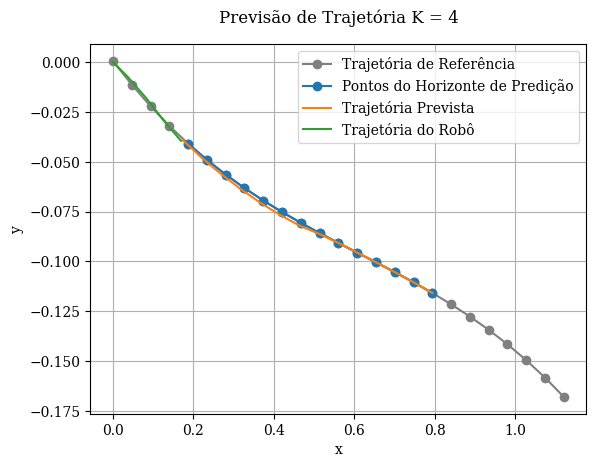

out_X [0.16925282735258007, 0.21568611857501893, 0.26435247119397787, 0.31326556235851516, 0.3622471731188076, 0.41130757441732463, 0.46045219053871667, 0.5096458396686095, 0.5587635159342916, 0.607409030586321, 0.6543652910124673, 0.7011059715947012, 0.7478463755481806, 0.7945867604465235, 0.8413263313115783]
out_Y [-0.039482540511155635, -0.04769154739916971, -0.055599001173686595, -0.06301781180125349, -0.06991101518731843, -0.07628903207228242, -0.0821747982761288, -0.08755529176257294, -0.09227691038498088, -0.09575401086144232, -0.10040778305480062, -0.10533545785517619, -0.11043126894801665, -0.1157844172772892, -0.12148305873592057]
out_v_R [0.9999996998738127, 0.999999612637485, 0.9999994790943697, 0.9999992629018739, 0.9999988785121794, 0.9999980940160451, 0.9999960988279702, 0.9999883947044785, 0.999869756625279, 0.9162971379040596, 0.9337425296813858, 0.9367903467107396, 0.9354808885381483, 0.9344218396130427, 9.899360405188935e-17]
out_v_L [0.886134262636226, 0.97218362527

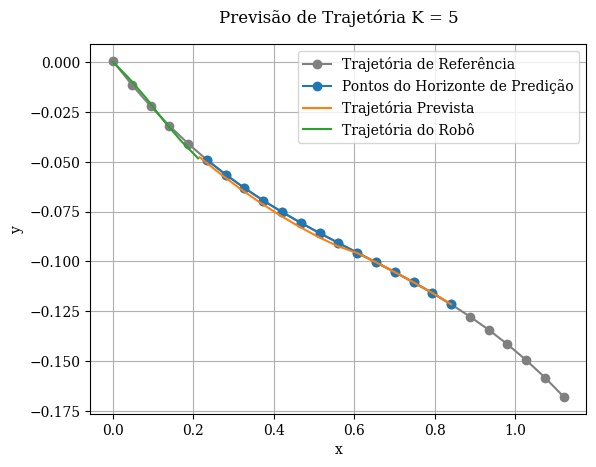

out_X [0.21190584166194515, 0.25884259126793113, 0.3078598103259302, 0.3570560491713956, 0.40627020946766046, 0.45552475379691487, 0.5048424108198563, 0.5542173676016413, 0.6035896185270191, 0.6527691865184861, 0.7011050558458651, 0.7478460105251409, 0.7945867788960639, 0.8413271591316719, 0.8880667098273474]
out_Y [-0.04825447244453954, -0.055473268960353525, -0.06253423030470034, -0.06927585231336109, -0.07564372070715338, -0.08163410341706223, -0.08727093946369897, -0.09257341840621285, -0.09749338011866185, -0.10176467950319937, -0.10533789598817367, -0.11043046985484645, -0.11578426355073673, -0.12148347653932842, -0.12761680776310605]
out_v_R [0.9999997677857492, 0.999999704976274, 0.9999996125712769, 0.9999994703047521, 0.9999992343158781, 0.9999987996087449, 0.9999978641723428, 0.999995260183964, 0.9999828088206036, 0.9821984561378373, 0.9056166783171044, 0.9354075628272083, 0.9344420249420653, 0.9336614082141821, 2.7164496261006925e-17]
out_v_L [0.8995452247685172, 0.980927324

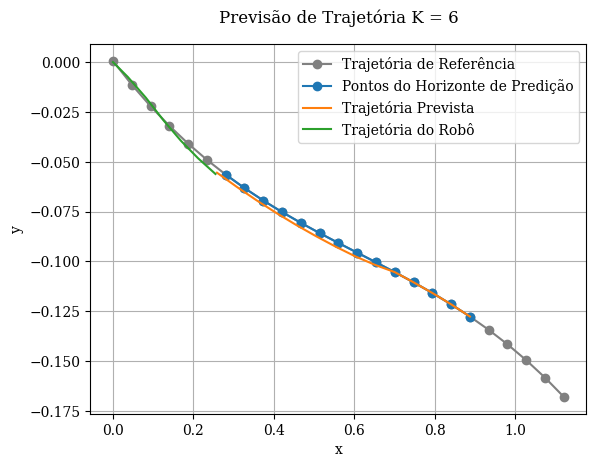

out_X [0.2550604564064962, 0.3023931028697834, 0.3516469486765087, 0.40104458626982786, 0.4504403282296874, 0.49985607988705266, 0.5493211251133889, 0.5988424189505552, 0.6483887370347367, 0.6978661681068289, 0.7469544219553693, 0.7945864480905208, 0.8413270428161866, 0.8880675587277768, 0.9348070795160704]
out_Y [-0.056112381170026815, -0.0625668559798631, -0.06894797065461784, -0.0751298109648829, -0.08106134815177084, -0.08673523000363727, -0.0921779669735832, -0.09742506459892512, -0.10247792106448916, -0.10722935260185873, -0.11120152642070406, -0.11578459092311477, -0.12148288223811224, -0.1276173301415852, -0.13427408949075667]
out_v_R [0.9999998112523251, 0.9999997633291104, 0.999999694874909, 0.9999995932652224, 0.9999994328277653, 0.9999991573111638, 0.9999986246584548, 0.99999739221274, 0.9999935131333829, 0.9999696648633603, 0.9418603760242337, 0.9163416263745506, 0.9336426491115916, 0.9332513489216318, -4.409274973103249e-17]
out_v_L [0.9108281417359658, 0.9866194485733846

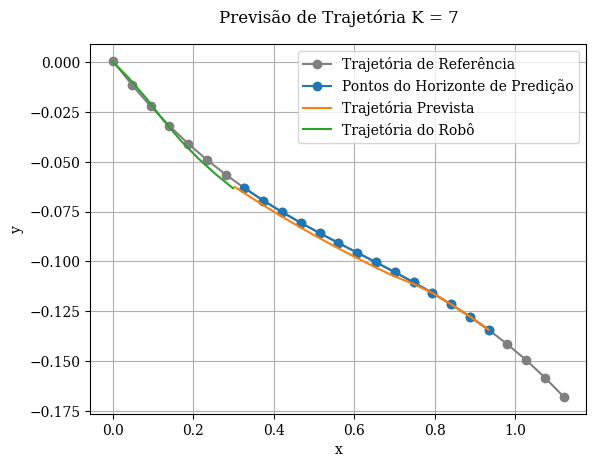

out_X [0.29860937929454673, 0.3462191455932403, 0.39564237632251087, 0.44519643780131213, 0.49473953667448745, 0.5442932395065967, 0.593886508056942, 0.643536349464678, 0.6932233140685835, 0.742905628966437, 0.7924346819461074, 0.841312539978625, 0.888066658218144, 0.9348079554108676, 0.9815480218071898]
out_Y [-0.06326355066549133, -0.06910549495280464, -0.07493517328498989, -0.08066384789160667, -0.08624746973580938, -0.09168268632441538, -0.09699925264253444, -0.10224810701473304, -0.1074603256077739, -0.1126215821788649, -0.11753958901019453, -0.12149917783465776, -0.12761567904754897, -0.13427453134485431, -0.14154392036138286]
out_v_R [0.9999999486045552, 0.999999934654228, 0.9999999151338876, 0.9999998868681482, 0.9999998436652385, 0.99999977266575, 0.9999996436650532, 0.9999993716635539, 0.9999986385803681, 0.9999953684433451, 0.9988971187532214, 0.8937995248926992, 0.9328388815911962, 0.9332574976617536, 1.021830517915335e-16]
out_v_L [0.9186738267050925, 0.9906344908864002, 0

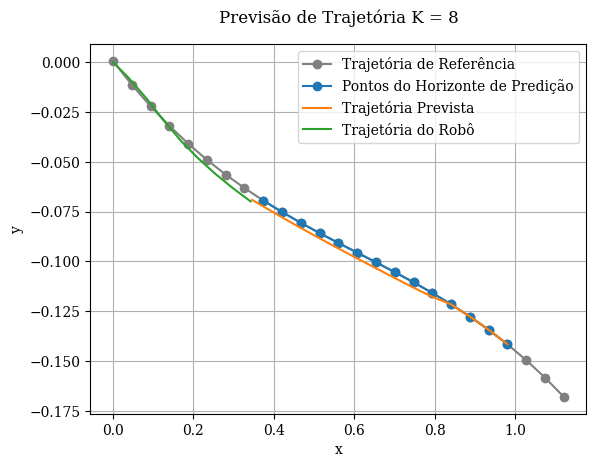

out_X [0.34243599383605705, 0.3902353801869252, 0.4397919663271862, 0.48947809519471414, 0.5391785850204687, 0.5888870210815066, 0.6385983664531569, 0.6883107314674213, 0.7380234354801527, 0.7877360397288916, 0.8374473970608333, 0.8870178058309404, 0.9348076121383752, 0.9815479576950311, 1.0282877891716675]
out_Y [-0.06984819169972276, -0.07517772891119211, -0.08054960944023648, -0.08590983479870785, -0.09125908394379664, -0.09660416252374607, -0.10194722792898787, -0.10728896637108475, -0.1126295427309331, -0.11796871396092501, -0.12330496543714156, -0.1284652704193392, -0.13427522393893376, -0.14154366419179792, -0.14951429815942227]
out_v_R [0.9999998633661845, 0.9999998319408184, 0.9999997887639587, 0.9999997275667624, 0.9999996364480217, 0.9999994920425364, 0.999999243714602, 0.9999987651877146, 0.9999976691390496, 0.9999942805717369, 0.9999737255653137, 0.945581282150674, 0.9127505193190036, 0.9336557336631669, 8.46955242815924e-17]
out_v_L [0.9238235352631381, 0.9938757057164525

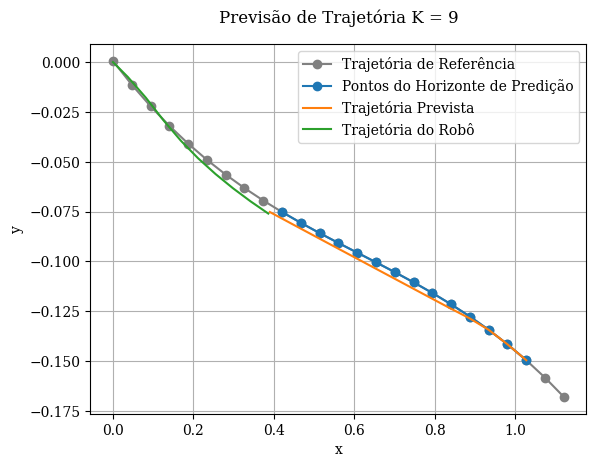

out_X [0.38645464894915654, 0.43463800193856655, 0.48435089193885444, 0.534063928326208, 0.5837770105203335, 0.6334901144476213, 0.6832032286198645, 0.7329163440305582, 0.7826294491374901, 0.8323425210349331, 0.8820554908887853, 0.9317679562096889, 0.9803797247081608, 1.0277690013376943, 1.0750207474763345]
out_Y [-0.07595910243627488, -0.08114286295223692, -0.08649091385297192, -0.09183885344811386, -0.09718671063960217, -0.10253450161923451, -0.10788223595115828, -0.11322991996383049, -0.11857755939925838, -0.1239251650016921, -0.12927277772259255, -0.1346207005382652, -0.14082878721042785, -0.14876772099186095, -0.1582631140302937]
out_v_R [0.9999998819126368, 0.999999854123708, 0.9999998154430079, 0.9999997601575807, 0.9999996772143398, 0.9999995450016731, 0.9999993168824938, 0.999998877764871, 0.9999978823657624, 0.9999949068543356, 0.9999786515963519, 0.9602765353985875, 0.9220285859081647, 0.9315997472150505, -9.037837971097459e-17]
out_v_L [0.9384559482092728, 0.99998937807673,

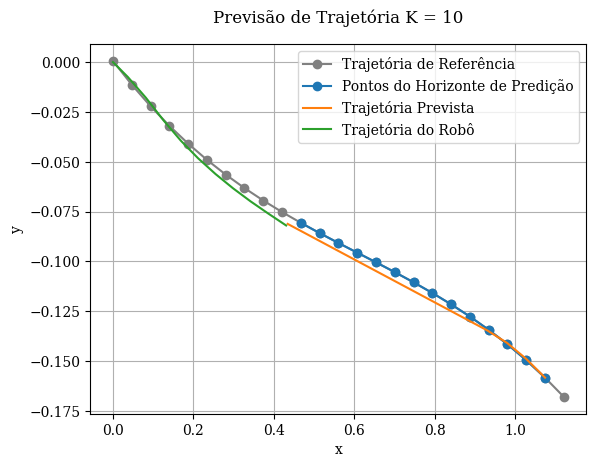

<Figure size 640x480 with 0 Axes>

In [209]:

# theta_ref = np.arctan2(np.gradient(y_ref), np.gradient(x_ref))
# x_margin_sup = x_ref + margin * np.cos(theta_ref + np.pi/2)
# y_margin_sup = y_ref + margin * np.sin(theta_ref + np.pi/2)
# x_margin_inf = x_ref - margin * np.cos(theta_ref + np.pi/2)
# y_margin_inf = y_ref - margin * np.sin(theta_ref + np.pi/2)

# print('iniciando simulação')
# print('len xref', len(x_ref))

# Parâmetros do ruído
x_ref = x_smooth
y_ref = y_smooth

# # # Simulação
dt = delta_time
x_traj = [0]
y_traj = [0]
v_out = []

robot_out = DifferentialDriveRobot(radius_wheel, distance_wheel)
mpc_out = MPCController(robot_out, N=predict_horizon, Q=1, R=0, dt=delta_time, max_margin=margin)


for i in range(len(x_ref) - predict_horizon):  # Garantir que o loop seja executado
    v_R, v_L, [out_x, out_y], [out_v_R, out_v_L] = mpc_out.solve(x_ref[i:i+predict_horizon], y_ref[i:i+predict_horizon])
    v_out.append((v_R, v_L))
    robot_out.update(v_R*0.9, v_L*0.95, dt)
    x_traj.append(robot_out.x)
    y_traj.append(robot_out.y)

    # Plotar trajetória com margem
    plt.title(f'Previsão de Trajetória K = {i + 1}', pad=15)
    plt.plot(x_ref, y_ref, 'o-',color='grey', label='Trajetória de Referência')
    plt.plot(x_ref[i + 1: i + predict_horizon], y_ref[i + 1: i + predict_horizon], 'o-', label='Pontos do Horizonte de Predição')
    plt.plot(out_x[1:], out_y[1:], '-', label='Trajetória Prevista')
    plt.plot(x_traj, y_traj, '-', label='Trajetória do Robô')
    # plt.fill_between(x_ref, y_margin_inf, y_margin_sup, color='gray', alpha=0.3, label=f'Margem de {margin} m')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.savefig(plt_sim_path + f'trajectory_out_{i}')
    plt.show()
    plt.clf() 

# # v_R, v_L, out_x, out_y = mpc.solve(x_ref[0:predict_horizon], y_ref[0:predict_horizon])
# # v_out.append((v_R, v_L))
# # robot.update(v_R, v_L, dt)
# # x_traj.append(robot.x)
# # y_traj.append(robot.y)

# print('v_out', v_out)
# print('v_out.len', len(v_out))




